In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pystan
from sklearn import datasets
from py_stan_code.helper_functions import StanModel_cache

%matplotlib inline 

<h2>Compile Stan Code</h2>

In [3]:
def stan_model(file):
    with open(file) as f:
        stan_code = f.read()
    return StanModel_cache(model_code=stan_code)
    
    
file1 = "py_stan_code/kppca_house.stan"
file2 = "py_stan_code/kppca.stan"

kppca_house_model = stan_model(file1)
kppca_model = stan_model(file2)

Using cached StanModel
Using cached StanModel


In [4]:
def run_calc(model, Y, N, D, Q, chains=4, iterations=1000):
    data_dict = {'N':N, 'D':D, 'Q':Q, 'Y':Y}
    samples = model.sampling(data_dict, chains=chains, iter=iterations)
    return samples

<h1>Breast Cancer Dataset</h1>

In [5]:
Q_fit =  2

Y =  datasets.load_breast_cancer()["data"]
Y = ((Y - Y.mean(axis=0))/Y.std(axis=0))
N,D = Y.shape

In [6]:
chains, iterations = 4, 1000

%time kppca = run_calc(kppca_model, Y, N, D, Q_fit, chains, iterations)
%time kppca_house = run_calc(kppca_house_model, Y, N, D, Q_fit, chains, iterations)

CPU times: user 22.5 s, sys: 10.3 s, total: 32.8 s
Wall time: 3h 23min 27s
CPU times: user 21.5 s, sys: 10.2 s, total: 31.6 s
Wall time: 3h 26min 45s


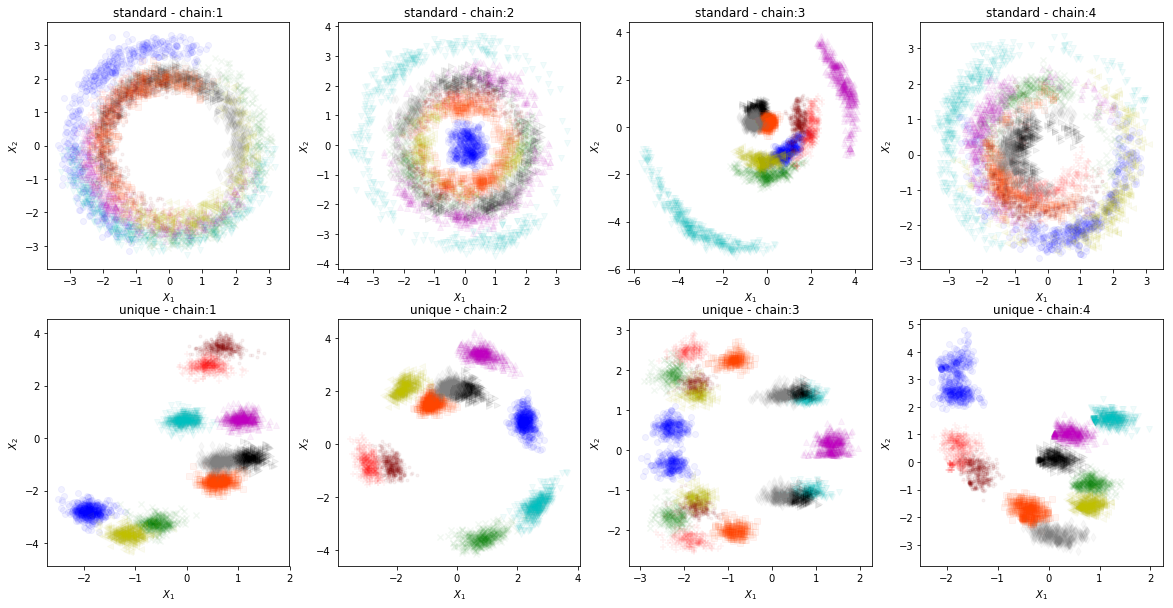

In [7]:
W_kppca_house = kppca_house.extract(['W_n'])['W_n']
W_kppca = kppca.extract(['W'])['W']


c = 5*['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orangered', 'grey', 'darkred', 
     'lawngreen', 'indigo', 'deeppink', 'deepskyblue', 'goldenrod']
marker = 5*['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', '.', ',', 'o', 'x', '+', 'v']
def plt_info(ax, x=None, y=None, legend=None, title=None):
    if x is not None: ax.set_xlabel(x)
    if y is not None: ax.set_ylabel(y)
    if legend is not None: ax.legend()
    if title is not None: ax.set_title(title)

        
jump = int(iterations/2)
l_tmp = [i*jump for i in range(chains)]

#show N_show random columns of W 
N_show = 10
ns = np.arange(0, W_kppca_house.shape[1])
np.random.shuffle(ns)
ns = ns[:N_show]


fig = plt.figure(figsize=(20,10))

for i,start in enumerate(l_tmp):
    ax = fig.add_subplot(2,chains,1+i)
    for j, n in enumerate(ns):
        ax.scatter(W_kppca[start:start+jump,n,0], W_kppca[start:start+jump,n,1], 
                   alpha=0.05, c=c[j], marker=marker[j], rasterized=True)
    plt_info(ax, '$X_1$', '$X_2$', title='standard - chain:{}'.format(i+1))

for i,start in enumerate(l_tmp):
    ax = fig.add_subplot(2,chains,chains+1+i)
    for j, n in enumerate(ns):
        ax.scatter(W_kppca_house[start:start+jump,n,0], W_kppca_house[start:start+jump,n,1], 
                   alpha=0.05, c=c[j], marker=marker[j], rasterized=True)
    plt_info(ax, '$X_1$', '$X_2$', title='unique - chain:{}'.format(i+1))
    
    
plt.show()
